# Synthetic expression data from cellular reprogramming network

In [1]:
import pandas as pd
import numpy as np
import random
from colomoto.minibn import * # for Boolean network manipulation
import networkx as nx # for graph manipulation
from scboolseq import scBoolSeq

# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)
random.seed(_rng_seed)

This notebook has been executed using the docker image `bnediction/scboolseq:v0`

## Load Boolean network

In [2]:
bn = BooleanNetwork.load("models/reprogramming.bnet")
bn

G1 <- TF1
G2 <- TF1
G3 <- TF1
G4 <- TF2
G5 <- TF2
G6 <- TF2
G7 <- TF6
G8 <- TF6
G9 <- TF6
TF1 <- TF3&!TF2
TF2 <- TF3&!TF1
TF3 <- TF4
TF4 <- TF5
TF5 <- !TF6
TF6 <- !TF7
TF7 <- 1

# computing graph layout...


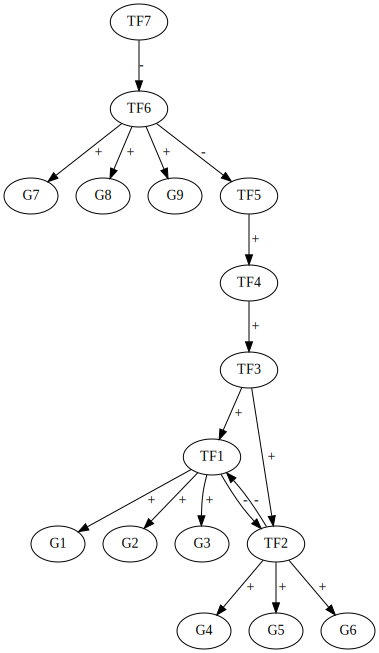

In [3]:
bn.influence_graph()

## Extract trajectories from the state transition graph

We consider the initial state where TF6 (and related G7-G9 genes) are active, as well as TF7 which will trigger the reprogramming.

In [4]:
initial_state = bn.zero()
for node in ["TF7", "TF6", "G7", "G8", "G9"]:
    initial_state[node] = 1
initial_state

{'G1': 0,
 'G2': 0,
 'G3': 0,
 'G4': 0,
 'G5': 0,
 'G6': 0,
 'G7': 1,
 'G8': 1,
 'G9': 1,
 'TF1': 0,
 'TF2': 0,
 'TF3': 0,
 'TF4': 0,
 'TF5': 0,
 'TF6': 1,
 'TF7': 1}

We compute the state transition graph from the initial state, using the fully asynchronous update mode:

# computing graph layout...


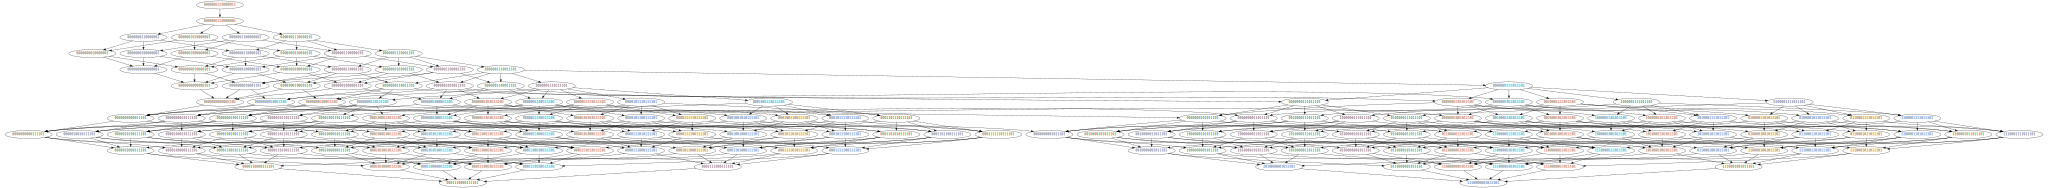

In [5]:
dynamics = FullyAsynchronousDynamics(bn)
stg = dynamics.partial_dynamics(initial_state)
stg

We can observe two stables states, both sharing TF7, and TF3-TF5 active, and one corresponding to TF1 active (and G1-G3), and one corresponding to TF2 (and G4-G6) active; the branching point is the state just before the activation of either TF1 or TF2.
The deactivation of G1-G3 (resulting from the deactivation of TF6) is interleaved with the differentiation process. Thus the bifurcation point is not uniquely determined as in the previous example.


In [6]:
# utility function to query the state-transition graph
def node_of_state(state):
    # convert a dict state to the binary representation
    return "".join([str(state[node]) for node in dynamics.nodes])
def extract_state(name):
    # convert the binary representation of a state to a dict
    return dict(zip(dynamics.nodes, map(int, name)))

init = node_of_state(initial_state)
print(f"{init=}")
branching_active = ["TF7", "TF3", "TF4", "TF5"]
branching = node_of_state({n: int(n in branching_active) for n in bn})
print(f"{branching=}")

init='0000001110000011'
branching='0000000000011101'


We get the two stable states by computing the attractors of the state-transition graph:

In [7]:
stables = [list(A)[0] for A in nx.attracting_components(stg)]
stables.sort()
stables # [0] is with TF2 active and [1] is with TF1 active

['0001110000111101', '1110000001011101']

Trajectory from initial state to first stable state:

In [8]:
common = nx.shortest_path(stg, init, branching)
traj1 = nx.shortest_path(stg, branching, stables[1])[1:]
traj2 = nx.shortest_path(stg, branching, stables[0])[1:]
binstates = pd.DataFrame(map(extract_state, common+traj1+traj2))

# label the states
labels = [f"common.{i}" for i in range(len(common)-1)] + ["switch"]\
         + [f"branch1.{i}" for i in range(len(traj1)-1)] + ["stable1"] \
         + [f"branch2.{i}" for i in range(len(traj2)-1)] + ["stable2"]
binstates.index = labels
binstates.index.name = "label"

binstates

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
label,,,,,,,,,,,,,,,,
common.0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1
common.1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1
common.2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
common.3,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1
common.4,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1
common.5,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1
common.6,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1
switch,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1
branch1.0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1


We select the common path and two paths from the branching state to the stable states:

## Retrieve statistics of real expression datasets

We re-use statistics computed from a real scRNA-Seq dataset ([1 - Binarization and synthetic data generation](1%20-%20Binarization%20and%20synthetic%20data%20generation.ipynb)):

In [9]:
criteria = pd.read_csv("cache_scBoolSeq_Nestorowa_simulation_criteria.csv", index_col=0)
criteria.head()

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
Clec1b,9.948487e-01,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal,NaN
Kdm3a,0.000000e+00,2.407548,-0.784019,0.326087,3.847940,0.209239,10.126676,0.714520,0.285480,0.872643,6.899449,1.278247,2.593177,8.692586,0.25,0.000000,5.258984,5.258984,1.268040,3.432251,4.748643,Bimodal,0.95
Coro2b,4.684039e-03,2.320060,0.327060,0.658213,2.383819,0.004597,9.475577,0.919508,0.080492,0.335546,6.289079,0.487372,2.383819,5.370521,0.25,0.827740,2.912944,2.085205,1.290666,3.183596,3.879537,Bimodal,NaN
8430408G22Rik,7.236739e-08,3.121069,-0.993979,0.884058,2.983472,0.005663,9.067857,0.964962,0.035038,0.098898,7.148808,0.172506,2.983472,8.154647,0.25,0.825298,6.465074,5.639776,1.449779,3.612061,4.175572,Bimodal,NaN
Clec9a,1.000000e+00,2.081717,140.089285,0.965580,2.280293,-0.009361,9.614233,0.993961,0.006039,0.035599,7.138099,0.069870,0.078488,0.372878,0.25,0.000000,0.000000,0.000000,0.000000,3.113410,4.607253,Discarded,0.95


In [10]:
criteria.Category.value_counts()

Bimodal      2987
Unimodal     1580
Discarded     201
Name: Category, dtype: int64

We randomly select bimodal genes for each of the nodes of the Boolean model to obtain simulation criteria:

In [11]:
pd.Series(bn.keys())

0      G1
1      G2
2      G3
3      G4
4      G5
5      G6
6      G7
7      G8
8      G9
9     TF1
10    TF2
11    TF3
12    TF4
13    TF5
14    TF6
15    TF7
dtype: object

In [12]:
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(len(bn), random_state=_rng_seed)
random_criteria.set_index(pd.Series(bn.keys()), inplace=True)
random_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
G1,0.000250,1.982430,-1.118390,0.027778,4.454848,2.231509,10.458465,0.634321,0.365679,2.449688,7.594680,1.562365,4.331102,7.707162,0.25,2.070391,6.920502,4.850112,3.321480,4.277351,6.081385,Bimodal,0.95
G2,0.000000,2.171544,-1.148314,0.021135,6.223047,8.243204,11.193184,0.363906,0.636094,2.579439,8.100760,1.496439,6.091521,8.558219,0.25,3.183970,8.483865,5.299895,7.282884,4.384796,5.990926,Bimodal,0.95
G3,0.000000,1.957530,-1.273249,0.044082,5.641087,8.029818,10.794851,0.409065,0.590935,2.258246,7.561991,1.774518,5.392416,8.579517,0.25,2.585510,7.994901,5.409391,6.129123,3.802762,5.780924,Bimodal,0.95
G4,0.000000,2.123630,-1.315039,0.036836,5.724870,8.076334,10.811316,0.400338,0.599662,2.237126,7.701644,1.589570,5.513990,8.763508,0.25,2.536712,8.106769,5.570057,6.452676,3.963904,5.713590,Bimodal,0.95
G5,0.000000,2.161170,-1.344687,0.018116,6.559400,9.543728,12.260558,0.403231,0.596769,2.734372,8.944811,1.987133,6.440570,11.275156,0.25,3.109483,9.439844,6.330361,7.471017,4.771986,6.660780,Bimodal,0.95
G6,0.000000,2.167416,-1.386505,0.038647,5.661639,8.154579,10.498523,0.436231,0.563769,2.322133,7.857554,1.604112,5.442832,9.145257,0.25,2.480269,8.141719,5.661451,6.272476,4.156733,5.870370,Bimodal,0.95
G7,0.000000,2.355317,-1.505761,0.034420,5.745117,8.722360,11.401288,0.433551,0.566449,2.015794,8.250379,1.720748,5.547368,11.273438,0.25,2.068712,8.581835,6.513123,6.533317,4.226884,5.879037,Bimodal,0.95
G8,0.000000,2.307954,-0.861903,0.005435,6.800339,8.655035,10.931065,0.303185,0.696815,2.875043,8.455204,1.234993,6.763381,7.818094,0.25,4.108445,8.919568,4.811123,7.855844,4.817005,6.135923,Bimodal,0.95
G9,0.000000,2.296122,-1.483351,0.043478,5.821394,8.961177,11.437198,0.489454,0.510546,2.422383,8.584236,1.799614,5.568290,11.294318,0.25,2.438392,8.763361,6.324968,5.836308,4.631891,6.354470,Bimodal,0.95
TF1,0.001038,1.593895,0.246388,0.035628,4.116075,3.382096,10.321775,0.813953,0.186047,3.118572,7.691919,1.246723,3.969428,4.416692,0.25,2.683685,4.560455,1.876770,3.506317,4.993969,6.611602,Bimodal,0.95


## Generate synthetic RNA-Seq data

In [13]:
scbool = scBoolSeq(simulation_criteria=random_criteria)
scbool

scBoolSeq(has_data=False, can_binarize=False, can_simulate=True)

In [14]:
n_samples = 300 # number of samples per row

In [15]:
counts = scbool.simulate(binstates, n_samples=n_samples, seed=1928327465)
counts.head()

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
label,,,,,,,,,,,,,,,,
common.0,2.332013,4.165573,3.036617,2.074770,2.986022,3.149574,8.866440,8.432784,7.435096,3.878601,2.611752,0.739442,1.212811,2.484502,9.225411,6.342557
common.1,0.983021,2.765827,1.046053,0.505312,2.334931,0.517259,7.515305,8.184479,9.757331,4.499499,3.500210,2.890799,3.691911,1.909916,0.917320,7.575461
common.2,1.051408,1.989230,2.231362,0.000000,3.933310,0.000000,9.997864,6.951664,5.752679,3.678492,3.249593,2.085020,2.751313,1.685234,2.143655,6.126514
common.3,1.872751,3.971206,4.966177,3.823021,1.890802,0.488222,8.886265,8.187462,3.301599,5.306327,2.982546,3.383870,0.929342,10.002958,3.271486,7.205930
common.4,1.469882,4.325479,0.199131,2.072330,2.122329,1.321206,10.573842,6.925085,3.149190,3.504758,2.624572,0.000000,8.181013,5.702311,2.322816,5.391876


In [16]:
counts.shape

(4800, 16)

We generate unique identifiers for each row (cell):

In [17]:
ids = [f"{x}_{y}"  for y in range(n_samples) for x in binstates.index]
counts.index = ids
counts.index.name = "cellID"
counts

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
cellID,,,,,,,,,,,,,,,,
common.0_0,2.332013,4.165573,3.036617,2.074770,2.986022,3.149574,8.866440,8.432784,7.435096,3.878601,2.611752,0.739442,1.212811,2.484502,9.225411,6.342557
common.1_0,0.983021,2.765827,1.046053,0.505312,2.334931,0.517259,7.515305,8.184479,9.757331,4.499499,3.500210,2.890799,3.691911,1.909916,0.917320,7.575461
common.2_0,1.051408,1.989230,2.231362,0.000000,3.933310,0.000000,9.997864,6.951664,5.752679,3.678492,3.249593,2.085020,2.751313,1.685234,2.143655,6.126514
common.3_0,1.872751,3.971206,4.966177,3.823021,1.890802,0.488222,8.886265,8.187462,3.301599,5.306327,2.982546,3.383870,0.929342,10.002958,3.271486,7.205930
common.4_0,1.469882,4.325479,0.199131,2.072330,2.122329,1.321206,10.573842,6.925085,3.149190,3.504758,2.624572,0.000000,8.181013,5.702311,2.322816,5.391876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stable1_299,6.614227,8.259758,6.124654,2.015079,0.086330,1.262856,4.279432,1.567930,3.742112,6.897451,4.061830,9.670800,8.335946,10.021983,3.009934,7.980499
branch2.0_299,1.781937,2.736619,1.064837,0.819506,2.788833,2.586831,2.540313,3.326951,1.588584,1.497111,7.355900,6.278719,6.536561,10.807584,1.486827,6.779317
branch2.1_299,4.394633,2.905205,3.133291,0.000000,3.897975,1.652100,2.137910,2.572199,0.462587,0.000000,8.628778,7.611550,8.305878,9.600482,3.353606,8.772373


Write as TSV file:

In [18]:
counts.T.to_csv("synthetic_data_reprogramming_counts.tsv", sep="\t")

We generate metadata to validate a trajectory reconstruction:

In [19]:
def label_of_index(idx):
    return idx.split(".")[0]
labels = [label_of_index(idx) for idx in binstates.index]

color_map = {
    "common": "#aec7e8",
    "switch": "#1f78b4",
    "branch1": "#98df8a",
    "stable1": "#2ca02c",
    "branch2": "#ff9896",
    "stable2": "#d62728"
}

In [20]:
metadata = [[l, color_map[l]] for l in labels]*n_samples
metadata = pd.DataFrame(metadata, columns=["label", "label_color"])
metadata.index = counts.index
metadata

,label,label_color
cellID,,
common.0_0,common,#aec7e8
common.1_0,common,#aec7e8
common.2_0,common,#aec7e8
common.3_0,common,#aec7e8
common.4_0,common,#aec7e8
...,...,...
stable1_299,stable1,#2ca02c
branch2.0_299,branch2,#ff9896
branch2.1_299,branch2,#ff9896


In [21]:
metadata.to_csv("synthetic_data_reprogramming_metadata.tsv", sep="\t")